In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
import zipfile

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

In [2]:
zf = zipfile.ZipFile('fer2013.zip') 
raw_data = pd.read_csv(zf.open('fer2013.csv'))
raw_data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
labels_mapping = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [4]:
def sep_data(df):
    '''
        Separates the train, validation and test data, according to the column 'usage' from the raw_data.
    '''
    train_data = df[df['Usage']=='Training'].reset_index().drop('index', axis=1)
    valid_data = df[df['Usage']=='PrivateTest'].reset_index().drop('index', axis=1)
    test_data = df[df['Usage']=='PublicTest'].reset_index().drop('index', axis=1)
    
    x_train = np.zeros((len(train_data),48,48))
    for i in range(len(train_data)):
        x_train[i] = np.array(train_data['pixels'][i].split()).astype(np.int).reshape(48,48)
    y_train = train_data.emotion
    
    x_valid = np.zeros((len(valid_data),48,48))
    for i in range(len(valid_data)):
        x_valid[i] = np.array(valid_data['pixels'][i].split()).astype(np.int).reshape(48,48)
    y_valid = valid_data.emotion
    
    x_test = np.zeros((len(test_data),48,48))
    for i in range(len(test_data)):
        x_test[i] = np.array(test_data['pixels'][i].split()).astype(np.int).reshape(48,48)
    y_test = test_data.emotion
    
    return x_train, y_train, x_test, y_test, x_valid, y_valid

In [13]:
x_train, y_train, x_test, y_test, x_valid, y_valid = sep_data(raw_data)

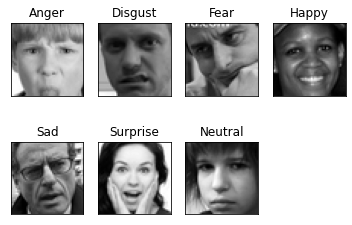

In [14]:
for i in range(len(labels_mapping)):
    emotion_ind = np.where(y_train==i)[0]
    ind = np.random.choice(emotion_ind)
    plt.subplot(2,4,i+1)
    plt.imshow(x_train[ind], cmap='gray')
    plt.title(labels_mapping[i])
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

In [15]:
def img_preproc(x_train, x_test, x_valid):
    
    x_train, x_test, x_valid = x_train/255.0, x_test/255.0, x_valid/255.0
    
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    x_test = np.expand_dims(x_test, -1)
    
    return x_train, x_test, x_valid

In [16]:
x_train, x_test, x_valid = img_preproc(x_train, x_test, x_valid)

In [17]:
# the number of classes
K = len(set(y_train))
print("the number of classes is {}.".format(K))

the number of classes is 7.


In [18]:
#Hyperparameters
filters1 = 64
filters2 = 128
filters3 = 256
filters4 = 512
kernel_size = (3,3)
activ1='relu'
dropout_perc = 0.1
pad = 'same'
maxp = (2,2)
mp2d_stride = (2,2)
dense_units = 4096

#Building the model VGG16 using the functional API

i = Input(shape=x_train[0].shape) # This instantiate the input

'''
I removed the strides because for this small images, normal convolution followed by MaxPooling peforms better
'''
x = Conv2D(filters1, kernel_size, activation=activ1, padding=pad)(i) # This does the 1st convolution.
x = BatchNormalization()(x)
x = Conv2D(filters1, kernel_size, activation=activ1, padding=pad)(x) # This does the 2nd convolution.
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=maxp, strides=mp2d_stride)(x)
x = Conv2D(filters2, kernel_size, activation=activ1, padding=pad)(x) # This does the 3rd convolution.
x = BatchNormalization()(x)
x = Conv2D(filters2, kernel_size, activation=activ1, padding=pad)(x) # This does the 4th convolution.
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=maxp, strides=mp2d_stride)(x)
x = Conv2D(filters3, kernel_size, activation=activ1, padding=pad)(x) # This does the 5th convolution.
x = BatchNormalization()(x)
x = Conv2D(filters3, kernel_size, activation=activ1, padding=pad)(x) # This does the 6th convolution.
x = BatchNormalization()(x)
x = Conv2D(filters3, kernel_size, activation=activ1, padding=pad)(x) # This does the 7th convolution.
x = BatchNormalization()(x)
x = Conv2D(filters3, kernel_size, activation=activ1, padding=pad)(x) # This does the 7th convolution.
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=maxp, strides=mp2d_stride)(x)
x = Conv2D(filters4, kernel_size, activation=activ1, padding=pad)(x) # This does the 8th convolution.
x = BatchNormalization()(x)
x = Conv2D(filters4, kernel_size, activation=activ1, padding=pad)(x) # This does the 9th convolution.
x = BatchNormalization()(x)
x = Conv2D(filters4, kernel_size, activation=activ1, padding=pad)(x) # This does the 10th convolution.
x = BatchNormalization()(x)
x = Conv2D(filters4, kernel_size, activation=activ1, padding=pad)(x) # This does the 10th convolution.
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=maxp, strides=mp2d_stride)(x)
x = Conv2D(filters4, kernel_size, activation=activ1, padding=pad)(x) # This does the 11th convolution.
x = BatchNormalization()(x)
x = Conv2D(filters4, kernel_size, activation=activ1, padding=pad)(x) # This does the 12th convolution.
x = BatchNormalization()(x)
x = Conv2D(filters4, kernel_size, activation=activ1, padding=pad)(x) # This does the 13th convolution.
x = BatchNormalization()(x)
x = Conv2D(filters4, kernel_size, activation=activ1, padding=pad)(x) # This does the 13th convolution.
x = BatchNormalization()(x)
#x = MaxPooling2D(pool_size=maxp, strides=mp2d_stride)(x)

# Using GlobalAveragePooling2D because in some previous trials it showed to deliver a better result.
x = GlobalAveragePooling2D()(x)


x = Flatten()(x) # We need to flatten in order to pass it to the Dense layers
x = Dropout(dropout_perc)(x)
x = Dense(4096, activation=activ1)(x)
x = Dropout(dropout_perc)(x)
x = Dense(4096, activation=activ1)(x)
x = Dropout(dropout_perc)(x)
x = Dense(K, activation='softmax')(x)

VGG19_bench_test = Model(i, x)

In [19]:
VGG19_bench_test.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
batch_size = 48

data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, 
                                                                 height_shift_range=0.1, 
                                                                 zoom_range=.1,
                                                                 horizontal_flip=True,
                                                                 rotation_range=10)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='benchmark_VGG19.hdf5', monitor='val_accuracy', mode='max', save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='min')

train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] / batch_size
fitted_model = VGG19_bench_test.fit(train_generator, validation_data=(x_valid, y_valid), steps_per_epoch=steps_per_epoch, epochs=60, callbacks=[model_checkpoint_callback, early_stop])

Epoch 1/60
599/598 [==============================] - 62s 103ms/step - loss: 1.6527 - accuracy: 0.3368 - val_loss: 2.2751 - val_accuracy: 0.3589
Epoch 2/60
599/598 [==============================] - 63s 105ms/step - loss: 1.3873 - accuracy: 0.4649 - val_loss: 1.4146 - val_accuracy: 0.4695
Epoch 3/60
599/598 [==============================] - 63s 104ms/step - loss: 1.2829 - accuracy: 0.5112 - val_loss: 1.2631 - val_accuracy: 0.5261
Epoch 4/60
599/598 [==============================] - 62s 103ms/step - loss: 1.2049 - accuracy: 0.5451 - val_loss: 1.5518 - val_accuracy: 0.4893
Epoch 5/60
599/598 [==============================] - 63s 105ms/step - loss: 1.1603 - accuracy: 0.5640 - val_loss: 1.2098 - val_accuracy: 0.5528
Epoch 6/60
599/598 [==============================] - 61s 102ms/step - loss: 1.1215 - accuracy: 0.5834 - val_loss: 1.3314 - val_accuracy: 0.5213
Epoch 7/60
599/598 [==============================] - 63s 105ms/step - loss: 1.0837 - accuracy: 0.5986 - val_loss: 1.1372 - val_ac

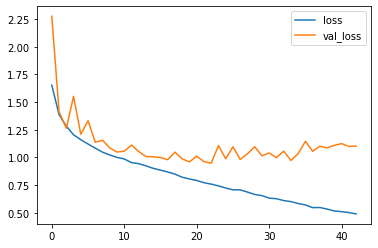

In [21]:
plt.plot(fitted_model.history['loss'], label='loss')
plt.plot(fitted_model.history['val_loss'], label='val_loss')
plt.legend()

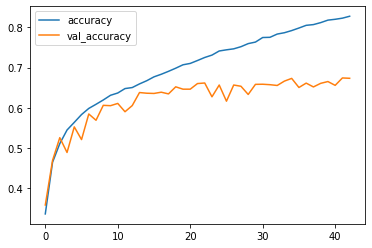

In [22]:
plt.plot(fitted_model.history['accuracy'], label='accuracy')
plt.plot(fitted_model.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [24]:
from tensorflow.keras.models import load_model
saved_model = load_model("benchmark_VGG19.hdf5")

Normalized confusion matrix


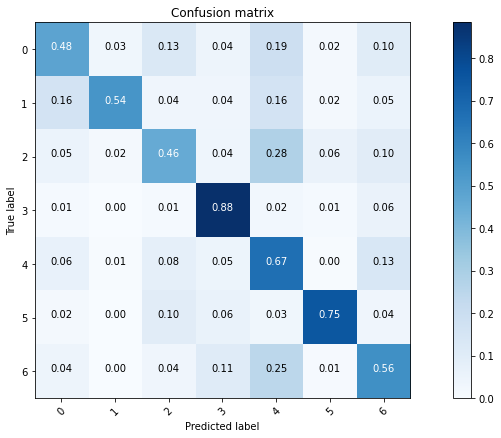

In [26]:
# plotting confusion matrix

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
  '''
    This function plots the confusion matrix. This part of the code was highly based on one done by lazyprogrammer (lazyprogrammer.me).
  '''
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('Confusion matrix not normalized.')
  
  plt.figure(figsize=(12,6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.0
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i,j],fmt),
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')
    
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

p_test = saved_model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(K)))


In [28]:
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(y_test, p_test)))

CNN Model Accuracy on test set: 0.6573
